## INVESTIGATE PLUTO ONLY, NO ADD/BBL MATCH TO PW

## Prepare datasets - PLUTO and PRESO

In [1]:
import geopandas as gpd
import pandas as pd
import geodatasets
from sqlalchemy import create_engine, text

import re

In [2]:
# Read shapefile
shapefile_path = '/Users/perchwellallusers/Downloads/nyc_mappluto_23v1_1_shp/MapPLUTO.shp'
gdf = gpd.read_file(shapefile_path)

# Print GeoDataFrame information
print(gdf.head())

  Borough  ...                                           geometry
0      MN  ...  POLYGON ((980898.728 191409.779, 980881.798 19...
1      MN  ...  MULTIPOLYGON (((972428.829 190679.175, 972443....
2      BK  ...  POLYGON ((986519.595 186440.526, 986475.486 18...
3      MN  ...  POLYGON ((973648.066 193711.894, 973525.342 19...
4      MN  ...  POLYGON ((980609.551 194220.421, 980608.726 19...

[5 rows x 95 columns]


In [4]:
pluto = pd.read_csv("/Users/perchwellallusers/Downloads/pluto_23v1.csv")

/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_25891/1775343207.py:1: DtypeWarning: Columns (21,22,24,26,66) have mixed types. Specify dtype option on import or set low_memory=False.
  pluto = pd.read_csv("/Users/perchwellallusers/Downloads/pluto_23v1.csv")


In [5]:
pluto = pluto[pluto['bbl'].isin(gdf.BBL.to_list())]

In [6]:
%load_ext sql

In [7]:
%sql postgresql://teleport:@localhost:2024/perchwell

In [ ]:
try:
    with open('./buildings.pkl', 'rb') as f:
        preso = pkl.load(f)
except:
    rowlist = []
    # Create the SQLAlchemy engine
    engine = create_engine('postgresql://teleport:@localhost:2024/perchwell')
    # Define the SQL query string
    for ran in range(0,800000,100000):
        currentrow = len(rowlist)
        
        query_string = f'''select b.*
            from buildings b
            ---join with geographies
            inner join building_geographies bg
                on b.id = bg.building_id
            ---filter for only NYC region code = 1278
            where bg.geography_id = 1278
                --and source_id is not null 
            LIMIT 100000 OFFSET {currentrow};
            '''
        try:
            # Execute the query
            with engine.connect() as conn:
                result = conn.execute(text(query_string))

                # Process the query result
                for row in result:
                    # Access the row data
                    rowlist.append(row)
            print(f'{len(rowlist)} rows appended')
        except:
            engine = create_engine('postgresql://teleport:@localhost:2024/perchwell')
            with engine.connect() as conn:
                result = conn.execute(text(query_string))
                for row in result:
                    rowlist.append(row)
            print(f'{len(rowlist)} rows appended')
    preso = pd.DataFrame(rowlist)
    with open('./buildings.pkl', 'wb') as f:
        pkl.dump(preso, f)

## MATCH PLUTO AND PW WITH BBL ONLY:

In [9]:
preso['source_id'] = pd.to_numeric(preso['source_id'])
matched_buildings = preso.merge(pluto, how='inner', left_on='source_id', right_on='bbl')
print(f'matched buildings: {matched_buildings.shape}\
      \nbuildings in preso: {preso.shape}\nbuildings in pluto: {pluto.shape}')

matched buildings: (730477, 183)      
buildings in preso: (749220, 91)
buildings in pluto: (856903, 92)


In [10]:
# Filter for unmatched in each and put into separate dataframes
in_preso = preso[~preso['id'].isin(matched_buildings['id'])]
in_pluto = pluto[~pluto['bbl'].isin(matched_buildings['bbl'])]

In [11]:
print(in_preso.shape, in_pluto.shape)

(18743, 91) (131122, 92)


## MATCH PLUTO AND PW WITH ADDRESS AND ZIP:

Steps for Address Matching:
1. strip trailing and leading whitespace from PW and PLUTO and convert to upper case
2. drop na from PLUTO addresses
3. convert zip codes to int
4. Convert written out numbers to numbers (i.e. first ave -> 1st ave)
5. Remove suffix of numbers
6. Match buildings based on the street address and zip code being the same

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
in_preso['display_address'] = in_preso['display_address'].str.upper().str.strip().copy()
in_pluto['address'] = in_pluto['address'].str.upper().str.strip().copy()
in_pluto = in_pluto.dropna(axis=0, subset=['address', 'zipcode'])
in_pluto['zipcode'] = in_pluto['zipcode'].astype(int, errors='ignore').copy()
in_preso['zip'] = in_preso['zip'].astype(int, errors='ignore').copy()

In [14]:
my_dict = {
  "FIRST": "1ST",
  "SECOND": "2ND",
  "THIRD": "3RD",
  "FOURTH": "4TH",
  "FIFTH": "5TH",
  "SIXTH": "6TH",
  "SEVENTH": "7TH",
  "EIGHTH": "8TH",
  "NINTH": "9TH",
  "TENTH": "10TH",
  "ELEVENTH": "11TH",
  "TWELFTH": "12TH",
  "THIRTEENTH": "13TH",
  "FOURTEENTH": "14TH",
  "FIFTEENTH": "15TH",
  "SIXTEENTH": "16TH",
  "SEVENTEENTH": "17TH",
  "EIGHTEENTH": "18TH",
  "NINETEENTH": "19TH",
  "TWENTIETH": "20TH",
  "TWENTY-FIRST": "21ST",
  "TWENTY-SECOND": "22ND",
  "TWENTY-THIRD": "23RD",
  "TWENTY-FOURTH": "24TH",
  "TWENTY-FIFTH": "25TH",
  "TWENTY-SIXTH": "26TH",
  "TWENTY-SEVENTH": "27TH",
  "TWENTY-EIGHTH": "28TH",
  "TWENTY-NINTH": "29TH",
  "THIRTIETH": "30TH",
  "THIRTY-FIRST": "31ST",
  "THIRTY-SECOND": "32ND",
  "THIRTY-THIRD": "33RD",
  "THIRTY-FOURTH": "34TH",
  "THIRTY-FIFTH": "35TH",
  "THIRTY-SIXTH": "36TH",
  "THIRTY-SEVENTH": "37TH",
  "THIRTY-EIGHTH": "38TH",
  "THIRTY-NINTH": "39TH",
  "FORTIETH": "40TH",
  "FORTY-FIRST": "41ST",
  "FORTY-SECOND": "42ND",
  "FORTY-THIRD": "43RD",
  "FORTY-FOURTH": "44TH",
  "FORTY-FIFTH": "45TH",
  "FORTY-SIXTH": "46TH",
  "FORTY-SEVENTH": "47TH",
  "FORTY-EIGHTH": "48TH",
  "FORTY-NINTH": "49TH",
  "FIFTIETH": "50TH",
  "FIFTY-FIRST": "51ST",
  "FIFTY-SECOND": "52ND",
  "FIFTY-THIRD": "53RD",
  "FIFTY-FOURTH": "54TH",
  "FIFTY-FIFTH": "55TH",
  "FIFTY-SIXTH": "56TH",
  "FIFTY-SEVENTH": "57TH",
  "FIFTY-EIGHTH": "58TH",
  "FIFTY-NINTH": "59TH",
  "SIXTIETH": "60TH",
  "SIXTY-FIRST": "61ST",
  "SIXTY-SECOND": "62ND",
  "SIXTY-THIRD": "63RD",
"SIXTY-FOURTH": "64TH",
"SIXTY-FIFTH": "65TH",
"SIXTY-SIXTH": "66TH",
"SIXTY-SEVENTH": "67TH",
"SIXTY-EIGHTH": "68TH",
"SIXTY-NINTH": "69TH",
"SEVENTIETH": "70TH",
"SEVENTY-FIRST": "71ST",
"SEVENTY-SECOND": "72ND",
"SEVENTY-THIRD": "73RD",
"SEVENTY-FOURTH": "74TH",
"SEVENTY-FIFTH": "75TH",
"SEVENTY-SIXTH": "76TH",
"SEVENTY-SEVENTH": "77TH",
"SEVENTY-EIGHTH": "78TH",
"SEVENTY-NINTH": "79TH",
"EIGHTIETH": "80TH",
"EIGHTY-FIRST": "81ST",
"EIGHTY-SECOND": "82ND",
"EIGHTY-THIRD": "83RD",
"EIGHTY-FOURTH": "84TH",
"EIGHTY-FIFTH": "85TH",
"EIGHTY-SIXTH": "86TH",
"EIGHTY-SEVENTH": "87TH",
"EIGHTY-EIGHTH": "88TH",
"EIGHTY-NINTH": "89TH",
"NINETIETH": "90TH",
"NINETY-FIRST": "91ST",
"NINETY-SECOND": "92ND",
"NINETY-THIRD": "93RD",
"NINETY-FOURTH": "94TH",
"NINETY-FIFTH": "95TH",
"NINETY-SIXTH": "96TH",
"NINETY-SEVENTH": "97TH",
"NINETY-EIGHTH": "98TH",
"NINETY-NINTH": "99TH",
"ONE HUNDREDTH": "100TH"
}

In [15]:
def remove_suffix(df, field_name):
    return df[field_name].replace("(?<=\d)(st|nd|rd|th)\b", '', regex=True).copy()

def convert_nums(df, field_name):
    new_dict = {key.replace("-", " "): value for key, value in my_dict.items()}
    new_keys = list(new_dict.keys())
    new_values = list(new_dict.values())
    for i in range(len(new_dict)):
        df[field_name] =  df[field_name].str.replace(new_keys[i], new_values[i]).copy()
    return df

In [16]:
in_preso = in_preso[in_preso['in_search'] == True]

In [17]:
first_matches = in_preso.merge(right=in_pluto, how='inner', left_on='display_address', right_on='address')
first_matches[first_matches['zip'] == first_matches['zipcode']]

,id,city,state,zip,google_map_params,building_bike_storage,building_doorman,building_elevator,building_gym,building_laundry,building_pets,building_pool,building_prewar,building_rooftop,building_storage,building_style_code,county_code,school_district_code,created_at,updated_at,neighborhood_id,source_id,display_address,display_name,building_garage,garage_type_code,year_built,benefit_construction_completed,num_stories,num_units,tax_class,centroid_latitude,centroid_longitude,tax_benefit_code,tax_benefit_start_date,tax_exemption_end_date,tax_abatement_end_date,j51_crc_perc,building_class,landmark_x,...,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark_y,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes


In [18]:
# convert numbers
new_dict = {key.replace('-', ' '): value for key, value in my_dict.items()}
new_keys = list(new_dict.keys())
new_values = list(new_dict.values())
for i in range(len(new_dict)):
    in_pluto['address'] = pluto.loc[:,'address'].str.replace(new_keys[i], new_values[i]).copy()
    in_preso['display_address'] = in_preso.loc[:,'display_address'].str.replace(new_keys[i], new_values[i]).copy()

In [19]:
in_pluto['address'] = [re.sub(r"(?<=\d)(ST|ND|RD|TH)\b", '', x) for x in in_pluto['address']]
in_preso['display_address'] = [re.sub(r"(?<=\d)(ST|ND|RD|TH)\b", '', x) for x in in_preso['display_address']]

In [20]:
second_matches = in_preso.merge(right=in_pluto, how='inner', left_on='display_address', right_on='address')
second_matches[second_matches['zip'] == second_matches['zipcode']]
len(second_matches)

648

## Filter for PLUTO only dataset

In [352]:
len(in_pluto)

129890

In [21]:
in_pluto = in_pluto[~in_pluto['bbl'].isin(second_matches.bbl.to_list())]

In [22]:
in_pluto = in_pluto[~in_pluto['bbl'].isin(first_matches.bbl.to_list())]

In [34]:
# Filter for only buildings we want to inspect WITHIN PW Region, put into a new df:
pluto_only = in_pluto[(in_pluto['borough']!='SI') & (in_pluto['longitude']<-73.74376451)]

In [35]:
in_pluto.merge(matched, how = 'inner', on = ['address','zipcode']).bbl_x.nunique()

473

In [36]:
pluto_only.merge(matched_buildings[['address','bbl','zipcode', 'id']], how='inner', on = ['address','zipcode']).bbl_x.nunique()

444

In [40]:
pluto_only = pluto_only[~pluto_only['bbl'].isin(dups_add_dif.bbl.to_list())]

In [41]:
pluto_only.duplicated(subset=['address','zipcode']).value_counts()

False    2602
True       88
dtype: int64

In [42]:
pluto_only[pluto_only.duplicated(subset=['address','zipcode'])]

,borough,block,lot,cd,bct2020,bctcb2020,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healthcenterdistrict,healtharea,sanitboro,sanitdistrict,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,...,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,firm07_flag,pfirm15_flag,version,dcpedited,latitude,longitude,notes
44833,QN,13911,140,413.0,4066401.0,4.066401e+10,664.0,1006.0,27.0,31.0,11422,E314,105.0,44.0,3620.0,4.0,13.0,7E,BROAD STREET,M1-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,V2,11.0,0.0,NaN,"CARRERO, KEVIN",4065.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,N,5.0,5.0,5880.0,5880.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.00,1.0,2.4,4,4.139110e+09,NaN,664.0,1054838.0,171819.0,25a,NaN,417 085,45703.0,NaN,NaN,NaN,1,1.0,1.0,23v1,NaN,40.637999,-73.745664,NaN
69957,BK,8845,2032,315.0,3062800.0,3.062800e+10,628.0,3016.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,BEACON COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,V0,11.0,0.0,NaN,ROBERT J CANZANELLA,1799.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,N,3.0,5.0,6480.0,6480.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.75,0.0,2.0,3,3.088452e+09,NaN,628.0,1006400.0,153327.0,29a,NaN,319 042,32605.0,NaN,NaN,NaN,1,NaN,1.0,23v1,NaN,40.587496,-73.920252,NaN
70017,BK,8932,642,315.0,3062800.0,3.062800e+10,628.0,1002.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,28 CELESTE COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,A1,1.0,0.0,NaN,WILLIAM MC CAFFREY,3570.0,1240.0,0.0,1240.0,0.0,...,25.0,40.0,N,1.0,N,3.0,5.0,17460.0,36720.0,1460.0,1920.0,1997.0,1997.0,NaN,NaN,0.35,0.75,0.0,2.0,3,3.089321e+09,NaN,628.0,1004608.0,155171.0,29a,NaN,319 038,32605.0,NaN,NaN,NaN,1,NaN,1.0,23v1,NaN,40.592561,-73.926698,NaN
70383,BK,8914,92,315.0,3062800.0,3.062800e+10,628.0,4004.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,CANTON COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,V0,11.0,0.0,NaN,"VASKO, MARCELA",1799.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,N,5.0,5.0,5580.0,5580.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.75,0.0,2.0,3,3.089140e+09,NaN,628.0,1005468.0,154152.0,29a,NaN,319 039,32605.0,NaN,NaN,NaN,1,NaN,1.0,23v1,NaN,40.589762,-73.923605,NaN
70457,BK,8914,400,315.0,3062800.0,3.062800e+10,628.0,4004.0,22.0,46.0,11229,E321,61.0,37.0,8900.0,3.0,15.0,4D,CANTON COURT,R4-1,NaN,NaN,NaN,NaN,NaN,CR-4,NaN,NaN,NaN,N,V0,11.0,0.0,NaN,"O'KEEFE, WILLIAM",1799.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,N,5.0,5.0,5580.0,5580.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.75,0.0,2.0,3,3.089140e+09,NaN,628.0,1005364.0,154273.0,29a,NaN,319 039,32605.0,NaN,NaN,NaN,1,NaN,1.0,23v1,NaN,40.590095,-73.923979,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813050,QN,13845,40,413.0,4066401.0,4.066401e+10,664.0,1000.0,29.0,31.0,11422,E314,105.0,44.0,3620.0,4.0,13.0,7E,NORTH STREET,R3-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,V0,11.0,0.0,NaN,DM REALTY USA LLC,1700.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,N,5.0,5.0,4500.0,4500.0,0.0,0.0,0.0,0.0,NaN,NaN,0.00,0.50,0.0,1.0,4,4.138450e+09,NaN,664.0,1055304.0,174492.0,25a,NaN,417 060,45703.0,NaN,NaN,NaN,1,1.0,1.0,23v1,NaN,40.645332,-73.743957,NaN
813057,QN,13864,35,413.0,4066401.0,4.066401e+10,664.0,1000.0,29.0,31.0,11422,E314,105.0,44.0,3620.0,4.0,13.0,7E,CANAL AVENUE,R3-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,V0,11.0,0.0,C,NYC DEPARTMENT OF PARKS AND RECREATION,2017.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,Y,5.0,5.0,4920.0,4920.0,4920.0,0.0,0.0,0.0,NaN,Na

In [43]:
pluto_only_nodups = pluto_only.drop_duplicates(subset=['address','zipcode'], keep = False)

In [46]:
# Filter for residential buildings - based on residential area (bldgclass is unreliable)
pluto_only_res_nodups = pluto_only_nodups[pluto_only_nodups.resarea > 0]

## Explorations and visualizations

In [ ]:
import plotly.express as px

# Assuming you have a dataframe 'df' with 'year' and 'value' columns
# Group the data by year and calculate the sum of values
df_grouped = pluto_only_res_nodups.groupby('yearbuilt').size().reset_index(name='count')

# Create the bar chart using Plotly
fig = px.bar(df_grouped[df_grouped.yearbuilt!=0], x='yearbuilt', y='count', labels={'value': 'Building Count'}, title='Sum of Values by Year')

# Show the chart
fig.show()


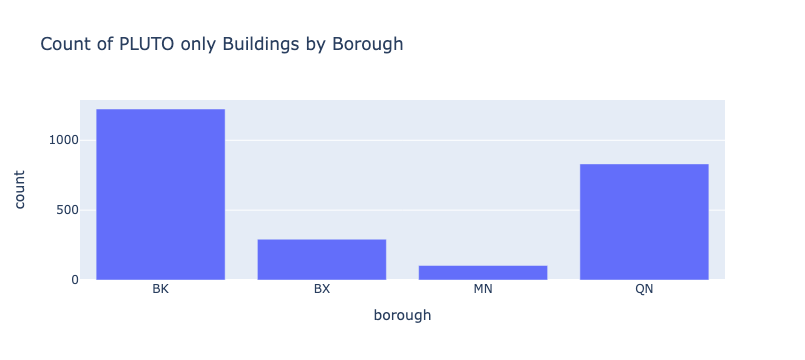

In [496]:

# Create the bar chart using Plotly
fig = px.bar(pluto_only_res_nodups.groupby('borough').size().reset_index(name='count'), x='borough', y='count', labels={'value': 'Building Count'}, title='Count of PLUTO only Buildings by Borough')

# Show the chart
fig.show()

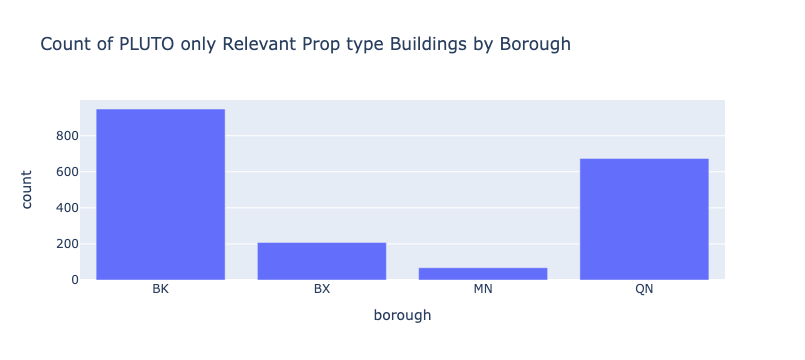

In [497]:
# Create the bar chart using Plotly
fig = px.bar(pluto_only_res_nodups[pluto_only_res_nodups['bldgclass'].str.startswith(tuple(['A','B','C','R','D','S']))].groupby('borough').size().reset_index(name='count')
             , x='borough', y='count', labels={'value': 'Building Count'}, title='Count of PLUTO only Relevant Prop type Buildings by Borough')

# Show the chart
fig.show()

In [507]:
resbuildings = pluto_only_res_nodups[pluto_only_res_nodups['bldgclass'].str.startswith(tuple(['A','B','C','R','D','S']))]
resbuildings['bldgclass'] = resbuildings['bldgclass'].str[0:1]

/var/folders/9s/qkj1lg4d22j6vzbkv4zxvqmm0000gp/T/ipykernel_94836/3205081795.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



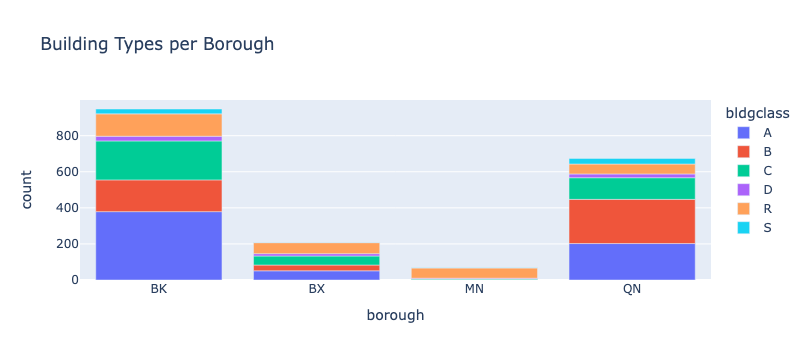

In [510]:
# Create the bar chart using Plotly
fig = px.bar(resbuildings.groupby(['borough','bldgclass']).size().reset_index(name = 'count'), x='borough', y='count', color = 'bldgclass', labels={'value': 'Building Count'}, title='Building Types per Borough')

# Show the chart
fig.show()

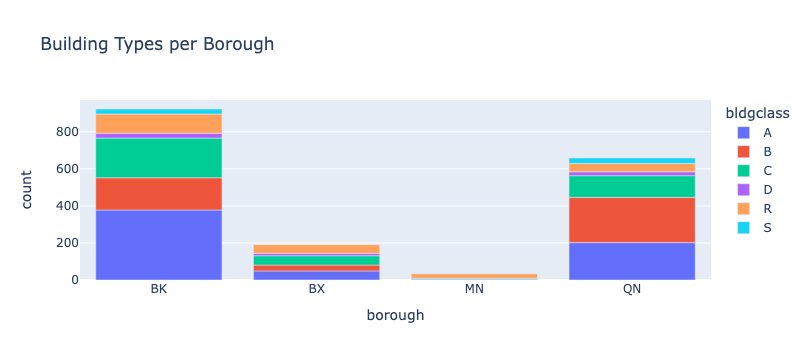

In [532]:
# Create the bar chart using Plotly
fig = px.bar(resbuildings.groupby(['borough','bldgclass']).size().reset_index(name = 'count'), x='borough', y='count', color = 'bldgclass', labels={'value': 'Building Count'}, title='Building Types per Borough')

# Show the chart
fig.show()

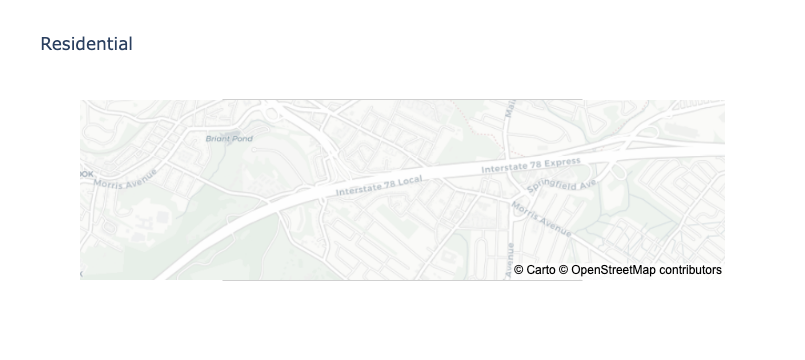

In [530]:
import geopandas as gpd
import pandas as pd
import plotly.graph_objects as go


# Create a trace for points
point_trace = go.Scattermapbox(
    lon=resbuildings['longitude'],
    lat=resbuildings['latitude'],
    mode='markers',
    marker=dict(color='blue', size=5),
        text=resbuildings['address']
)

# Create the layout
layout = go.Layout(
    title='Residential',
    showlegend=False,
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=40.7128, lon=-74.0060),
        zoom=11
    )
)

# Create the figure
fig = go.Figure(data=[polygon_trace, point_trace], layout=layout)

# Display the plot
fig.show()


In [531]:
# Export the figure to an HTML file
fig.write_html("PLUTO_Only.html")